Tugas 6 - Summary Dokumen Menggunakan Centrality

Nama : Isnita Widyur Rahmah
NIM : 220411100048
Kelas : IF 7A

Link Project : https://github.com/taawdyy/ppw

##Install Pustaka Python
pip install networkx digunakan untuk melakukan analisis graf serta visualisasi yang lebih baik

In [18]:
!pip install networkx matplotlib nltk tqdm pandas sklearn requests beautifulsoup4

  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


#Impor Pustaka untuk Analisis dan Visualisasi Data dan Graf
pandas dan numpy digunakan untuk analisis data, networkx untuk bekerja dengan graf.

In [48]:
import numpy as np
import pandas as pd
import requests
import re
import networkx as nx

from urllib.request import urlopen
from bs4 import BeautifulSoup

from tqdm import tqdm

import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
from nltk.tokenize import sent_tokenize , word_tokenize
from nltk.corpus import stopwords

from sklearn.metrics.pairwise import cosine_similarity
from sklearn import preprocessing

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


#Crawling Data Artikel Berita Menggunakan Python
melakukan crawling untuk mengambil judul, isi, tanggal, dan kategori artikel dari URL yang diberikan, dan menyajikan data tersebut dalam bentuk DataFrame untuk kemudahan analisis lebih lanjut.

In [19]:
def crawl_article(url):
    try:
        response = requests.get(url)
        response.raise_for_status()  # Memastikan permintaan berhasil
        soup = BeautifulSoup(response.content, 'html.parser')

        # Mengambil judul
        title_element = soup.find('h1', class_='text-cnn_black')
        title = title_element.get_text().strip() if title_element else 'Judul tidak ditemukan'

        # Mengambil Isi
        content_div = soup.find('div', class_='detail-text')
        content = "\n".join([p.get_text().strip() for p in content_div.find_all('p')]) if content_div else 'Isi artikel tidak ditemukan'

        # Mengambil tanggal
        date_div = soup.find('div', class_='text-cnn_grey text-sm mb-4')
        date_text = date_div.text.strip() if date_div else 'Tanggal tidak ditemukan'

        # Mengambil kategori
        category_meta = soup.find("meta", attrs={'name': 'dtk:namakanal'})
        category = category_meta['content'].strip() if category_meta and 'content' in category_meta.attrs else 'Kategori tidak ditemukan'

        return {'Judul': title, 'Isi': content, 'Tanggal': date_text, 'Kategori': category}
    except requests.RequestException as e:
        print(f"Error fetching article: {e}")
        return None

article_url = input("Masukkan URL artikel: ")

# Melakukan crawl pada satu artikel
article = crawl_article(article_url)

df = pd.DataFrame([article])  # Membuat DataFrame dari dictionary
df

Masukkan URL artikel: https://www.cnnindonesia.com/ekonomi/20241016175101-78-1156117/bi-buka-peluang-turunkan-bunga-acuan-lagi


,Judul,Isi,Tanggal,Kategori
0,BI Buka Peluang Turunkan Bunga Acuan Lagi,Gubernur Bank Indonesia (BI) Perry Warjiyo mem...,"Rabu, 16 Okt 2024 21:00 WIB",ekonomi


#Transformasi Teks Menjadi Huruf Kecil
mengubah semua teks dalam kolom Isi menjadi huruf kecil dan menyimpannya dalam kolom baru.

In [33]:
# Fungsi untuk mengubah teks menjadi huruf kecil
def clean_lower(text):
    if isinstance(text, str):
        return text.lower()
    return text

df['lower case'] = df['Isi'].apply(clean_lower)
df['lower case']

,lower case
0,gubernur bank indonesia (bi) perry warjiyo mem...


#Pembersihan Teks dari Tanda Baca dan Angka
membersihkan teks dari tanda baca dan angka, serta menghapus karakter yang tidak diinginkan, dan menyimpannya dalam kolom baru.

In [34]:
# Fungsi untuk membersihkan tanda baca dan angka (menghapus koma)
def clean_punct(text):
    if isinstance(text, str):
        clean_patterns = re.compile(r'[0-9]|[/(){}\[\]\|@,;_]|[^a-z .]+')  # Koma dihilangkan dari pengecualian
        text = clean_patterns.sub(' ', text)
        text = re.sub(r'\s+', ' ', text).strip()
        return text
    return text

df['tanda baca'] = df['lower case'].apply(clean_punct)
df['tanda baca']

,tanda baca
0,gubernur bank indonesia bi perry warjiyo membu...


#Normalisasi Spasi dalam Teks
melakukan normalisasi spasi dalam teks dengan mengganti beberapa spasi berturut-turut menjadi satu spasi dan menghapus spasi di awal dan akhir.

In [35]:
# Fungsi untuk normalisasi spasi
def _normalize_whitespace(text):
    if isinstance(text, str):
        corrected = re.sub(r'\s+', ' ', text)
        return corrected.strip()
    return text

df['spasi'] = df['tanda baca'].apply(_normalize_whitespace)
df['spasi']

,spasi
0,gubernur bank indonesia bi perry warjiyo membu...


#Tokenisasi Teks Menjadi Kata
melakukan tokenisasi pada teks yang telah dinormalisasi, memecahnya menjadi daftar kata atau token, dan menyimpannya dalam kolom baru.

In [39]:
# Tokenisasi
def tokenize_text(text):
    if isinstance(text, str):
        return word_tokenize(text)
    return text

df['token'] = df['spasi'].apply(tokenize_text)
df['token']

,token
0,"[gubernur, bank, indonesia, bi, perry, warjiyo..."


#Pembersihan Stopwords dari Token
membersihkan daftar token dari kata-kata umum yang tidak memberikan makna penting (stopwords), sehingga hanya kata-kata yang relevan yang tersisa untuk analisis lebih lanjut.

In [40]:
# Pembersihan stopwords setelah tokenisasi
def clean_stopwords(tokens):
    if isinstance(tokens, list):
        stopword = set(stopwords.words('indonesian'))
        filtered_tokens = [word for word in tokens if word not in stopword]
        return filtered_tokens
    return tokens

df['stopwords'] = df['token'].apply(clean_stopwords)
df['stopwords']

,stopwords
0,"[gubernur, bank, indonesia, bi, perry, warjiyo..."


#Penggabungan Token Menjadi Teks yang Diproses
menggabungkan kembali daftar token yang telah dibersihkan menjadi string utuh, yang kemudian dapat digunakan untuk analisis lebih lanjut.

In [41]:
# Gabungkan kembali token menjadi string
df['processed_text'] = df['stopwords'].apply(lambda tokens: ' '.join(tokens) if isinstance(tokens, list) else '')

prep_result = df['processed_text'].to_dict()
print(prep_result)

{0: 'gubernur bank indonesia bi perry warjiyo membuka peluang lembaganya menurunkan suku bunga acuan bi rate depannya . keputusan suku bunga mempertimbangkan tingkat inflasi nilai tukar rupiah pertumbuhan ekonomi . bank indonesia mencermati ruang penurunan suku bunga kebijakan memperhatikan prospek inflasi nilai tukar rupiah pertumbuhan ekonomi konferensi pers kantor bi kamis . advertisement scroll to continue with content perry jangka pendek bi fokus stabilitas nilai tukar rupiah meningkatnya ketidakpastian pasar keuangan global akibat ketegangan geopolitik timur . bidang ekonomi pertumbuhan dunia diprakirakan tumbuh persen kecenderungan melambat . inflasi global perry tren penurunan mendorong pelonggaran kebijakan moneter negara maju . amerika serikat as rilis tingkat pengangguran terkini perbaikan prospek inflasi rendah mendorong ekspektasi pelaku pasar penurunan fed funds rate ffr rendah prakiraan . menyebabkan kenaikan yield us treasury tenor indeks dolar as dxy . tren penurunan s

#Tokenisasi Kalimat pada Teks Diproses dan Asli
melakukan tokenisasi kalimat pada dua teks: satu dari teks yang telah diproses dan satu dari teks asli.

In [42]:
kalimat_preprocessing = nltk.sent_tokenize(prep_result[0])
kalimat = nltk.sent_tokenize(df['Isi'][0])

#Perhitungan TF-IDF untuk Kalimat yang Diproses
menghitung nilai TF-IDF dari kalimat yang telah diproses, memberikan representasi numerik dari kata-kata dalam kalimat tersebut.

In [43]:
tfidf_vectorizer = TfidfVectorizer()
tfidf_preprocessing = tfidf_vectorizer.fit_transform(kalimat_preprocessing)
terms = tfidf_vectorizer.get_feature_names_out()
tfidf_preprocessing = pd.DataFrame(data=tfidf_preprocessing.toarray(), columns=terms)
tfidf_preprocessing

,acuan,advertisement,akibat,aliran,amerika,arah,as,asing,bank,berkelanjutan,...,to,treasury,tren,tukar,tumbuh,us,video,warjiyo,with,yield
0,0.287579,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.221463,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.287579,0.000000,0.000000
1,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.282291,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.207229,0.000000,...,0.000000,0.000000,0.000000,0.187312,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.000000,0.223833,0.223833,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.223833,0.000000,0.000000,0.155806,0.000000,0.000000,0.000000,0.000000,0.223833,0.000000
4,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.379019,0.000000,0.000000,0.000000,0.000000,0.000000
5,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.329997,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,0.000000,0.000000,0.000000,0.000000,0.21923,0.000000,0.168828,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.248637,0.000000,0.000000,0.000000,...,0.000000,0.322866,0.000000,0.000000,0.000000,0.322866,0.000000,0.000000,0.000000,0.322866
8,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.246195,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.276701,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
9,0.000000,0.000000,0.000000,0.217635,0.00000,0.000000,0.000000,0.217635,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.151491,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


#Perhitungan Matriks Kesamaan Kosinus untuk Kalimat yang Diproses
menghitung dan menyajikan matriks kesamaan kosinus antara kalimat-kalimat yang telah diproses, yang dapat digunakan untuk analisis lebih lanjut, seperti klustering kalimat, pencarian dokumen serupa, atau pengelompokan informasi.

In [46]:
cossim_prep = cosine_similarity(tfidf_preprocessing, tfidf_preprocessing)

similarity_matrix = pd.DataFrame(cossim_prep,
								 index=range(len(kalimat_preprocessing)),
								 columns=range(len(kalimat_preprocessing)))

similarity_matrix

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,1.000000,0.094233,0.216842,0.078015,0.000000,0.044297,0.030548,0.000000,0.074285,0.000000,0.204545,0.141098,0.365655,0.032368
1,0.094233,1.000000,0.390911,0.141798,0.124195,0.062467,0.102520,0.000000,0.104756,0.156843,0.000000,0.198976,0.000000,0.221576
2,0.216842,0.390911,1.000000,0.118423,0.082409,0.132611,0.096610,0.000000,0.145949,0.127732,0.057414,0.132029,0.156533,0.121152
3,0.078015,0.141798,0.118423,1.000000,0.000000,0.085089,0.036760,0.000000,0.107211,0.149080,0.047757,0.000000,0.066162,0.025193
4,0.000000,0.124195,0.082409,0.000000,1.000000,0.000000,0.000000,0.000000,0.090771,0.066649,0.040434,0.092981,0.056017,0.170641
5,0.044297,0.062467,0.132611,0.085089,0.000000,1.000000,0.123839,0.000000,0.382234,0.131942,0.000000,0.000000,0.056350,0.208316
6,0.030548,0.102520,0.096610,0.036760,0.000000,0.123839,1.000000,0.041977,0.075524,0.028295,0.028049,0.000000,0.038860,0.024675
7,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.041977,1.000000,0.061213,0.000000,0.000000,0.000000,0.000000,0.000000
8,0.074285,0.104756,0.145949,0.107211,0.090771,0.382234,0.075524,0.061213,1.000000,0.028109,0.000000,0.156855,0.000000,0.035983
9,0.000000,0.156843,0.127732,0.149080,0.066649,0.131942,0.028295,0.000000,0.028109,1.000000,0.000000,0.000000,0.000000,0.118909


#Visualisasi Graf Kesamaan Kalimat Berbasis Kesamaan Kosinus
membuat dan memvisualisasikan graf berarah berdasarkan kesamaan kosinus antara kalimat-kalimat.

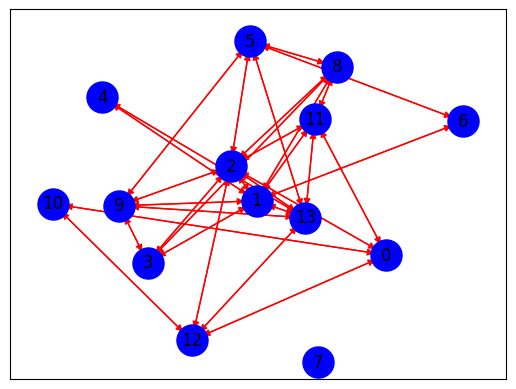

In [49]:
G_preprocessing = nx.DiGraph()
for i in range(len(cossim_prep)):
    G_preprocessing.add_node(i)

for i in range(len(cossim_prep)):
    for j in range(len(cossim_prep)):
        similarity_preprocessing = cossim_prep[i][j]
        if similarity_preprocessing > 0.1 and i != j:
            G_preprocessing.add_edge(i, j)

pos = nx.spring_layout(G_preprocessing, k=2)
nx.draw_networkx_nodes(G_preprocessing, pos, node_size=500, node_color='b')
nx.draw_networkx_edges(G_preprocessing, pos, edge_color='red', arrows=True)
nx.draw_networkx_labels(G_preprocessing, pos)

plt.show()

#Perhitungan dan Tampilkan Closeness Centrality dari Node Graf
menghitung dan menampilkan nilai closeness centrality untuk setiap node dalam graf berarah.

In [50]:
closeness_preprocessing = nx.closeness_centrality(G_preprocessing)

sorted_closeness_preprocessing = sorted(closeness_preprocessing.items(), key=lambda x: x[1], reverse=True)
print("Closeness Centrality:")
for node, closeness in sorted_closeness_preprocessing:
    print(f"Node {node}: {closeness:.4f}")

Closeness Centrality:
Node 2: 0.7385
Node 1: 0.6516
Node 13: 0.6516
Node 11: 0.5830
Node 5: 0.5538
Node 8: 0.5538
Node 9: 0.5538
Node 3: 0.5275
Node 12: 0.5275
Node 0: 0.5035
Node 4: 0.4615
Node 6: 0.4260
Node 10: 0.3692
Node 7: 0.0000


#Ringkasan Tiga Node Tertinggi Closeness Centrality dan Kalimat Terkait
mengekstrak dan menampilkan informasi mengenai tiga node dengan nilai closeness centrality tertinggi, termasuk kalimat yang terkait dengan node-node tersebut.

In [51]:
ringkasan_closeness_preprocessing = ""
print("Tiga Node Tertinggi Closeness Centrality Menggunakan Preprocessing:")
for node, closeness_preprocessing in sorted_closeness_preprocessing[:3]:
    top_sentence = kalimat[node]
    ringkasan_closeness_preprocessing += top_sentence + " "
    print(f"Node {node}: Closeness Centrality = {closeness_preprocessing:.4f}")
    print(f"Kalimat: {top_sentence}\n")

Tiga Node Tertinggi Closeness Centrality Menggunakan Preprocessing:
Node 2: Closeness Centrality = 0.7385
Kalimat: "Ke depan, Bank Indonesia terus mencermati ruang penurunan suku bunga kebijakan dengan tetap memperhatikan prospek inflasi, nilai tukar rupiah, dan pertumbuhan ekonomi," katanya dalam konferensi pers di kantor BI, Kamis (16/10).

Node 1: Closeness Centrality = 0.6516
Kalimat: Keputusan suku bunga katanya akan mempertimbangkan tingkat inflasi, nilai tukar rupiah, dan pertumbuhan ekonomi.

Node 13: Closeness Centrality = 0.6516
Kalimat: Menurut Perry, keputusan ini konsisten dengan arah kebijakan moneter untuk memastikan inflasi tetap terkendali dalam sasaran 2,5 persen plus minus 1 persen pada 2024 dan 2025 serta untuk mendukung pertumbuhan ekonomi yang berkelanjutan.

